# Dependency Tree Feature Analysis
## Visualizing All Features from Pre-Computed Data

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Setup visualization
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
tqdm.pandas()

## 1. Load and Prepare Data

In [11]:
# Load the expanded dataset
df = pd.read_csv("../data/temp_expanded_df.csv")  # Update path as needed

# Sample for faster plotting (remove for full dataset)
df = df.groupby('language_group').apply(lambda x: x.sample(min(len(x), 1000)).reset_index(drop=True))

# List all available features
node_features = [
    'eccentricity', 'degree_cent', 'harmoni_cent', 'betweeness_cent',
    'page_cent', 'eigen_cent', 'closeness_cent', 'katz_cent',
    'information_cent', 'load_centrality', 'subgraph_cent',
    'comm_betweenness', 'current_flow_closeness', 'current_flow_betweenness',
    'second_order_cent', 'degree', 'avg_shortest_path_length', 'effective_size',
    'vote_rank_score', 'is_leaf', 'largest_component_removed', 'num_subtrees_removed',
    'subtree_size_variance', 'participation_diameter', 'radiality',
    'neighbor_degree_mean', 'neighbor_degree_max', 'neighbor_degree_min', 'num_leaf_neighbors'
]

print(f"Loaded {len(df)} nodes with {len(node_features)} features")

Loaded 12000 nodes with 29 features


/var/folders/lr/ysc7n3fx6sv02d60ctrl7k_r0000gn/T/ipykernel_11369/3980185600.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('language_group').apply(lambda x: x.sample(min(len(x), 1000)).reset_index(drop=True))


## 2. Feature Visualization by Language Group


=== Centrality Features ===


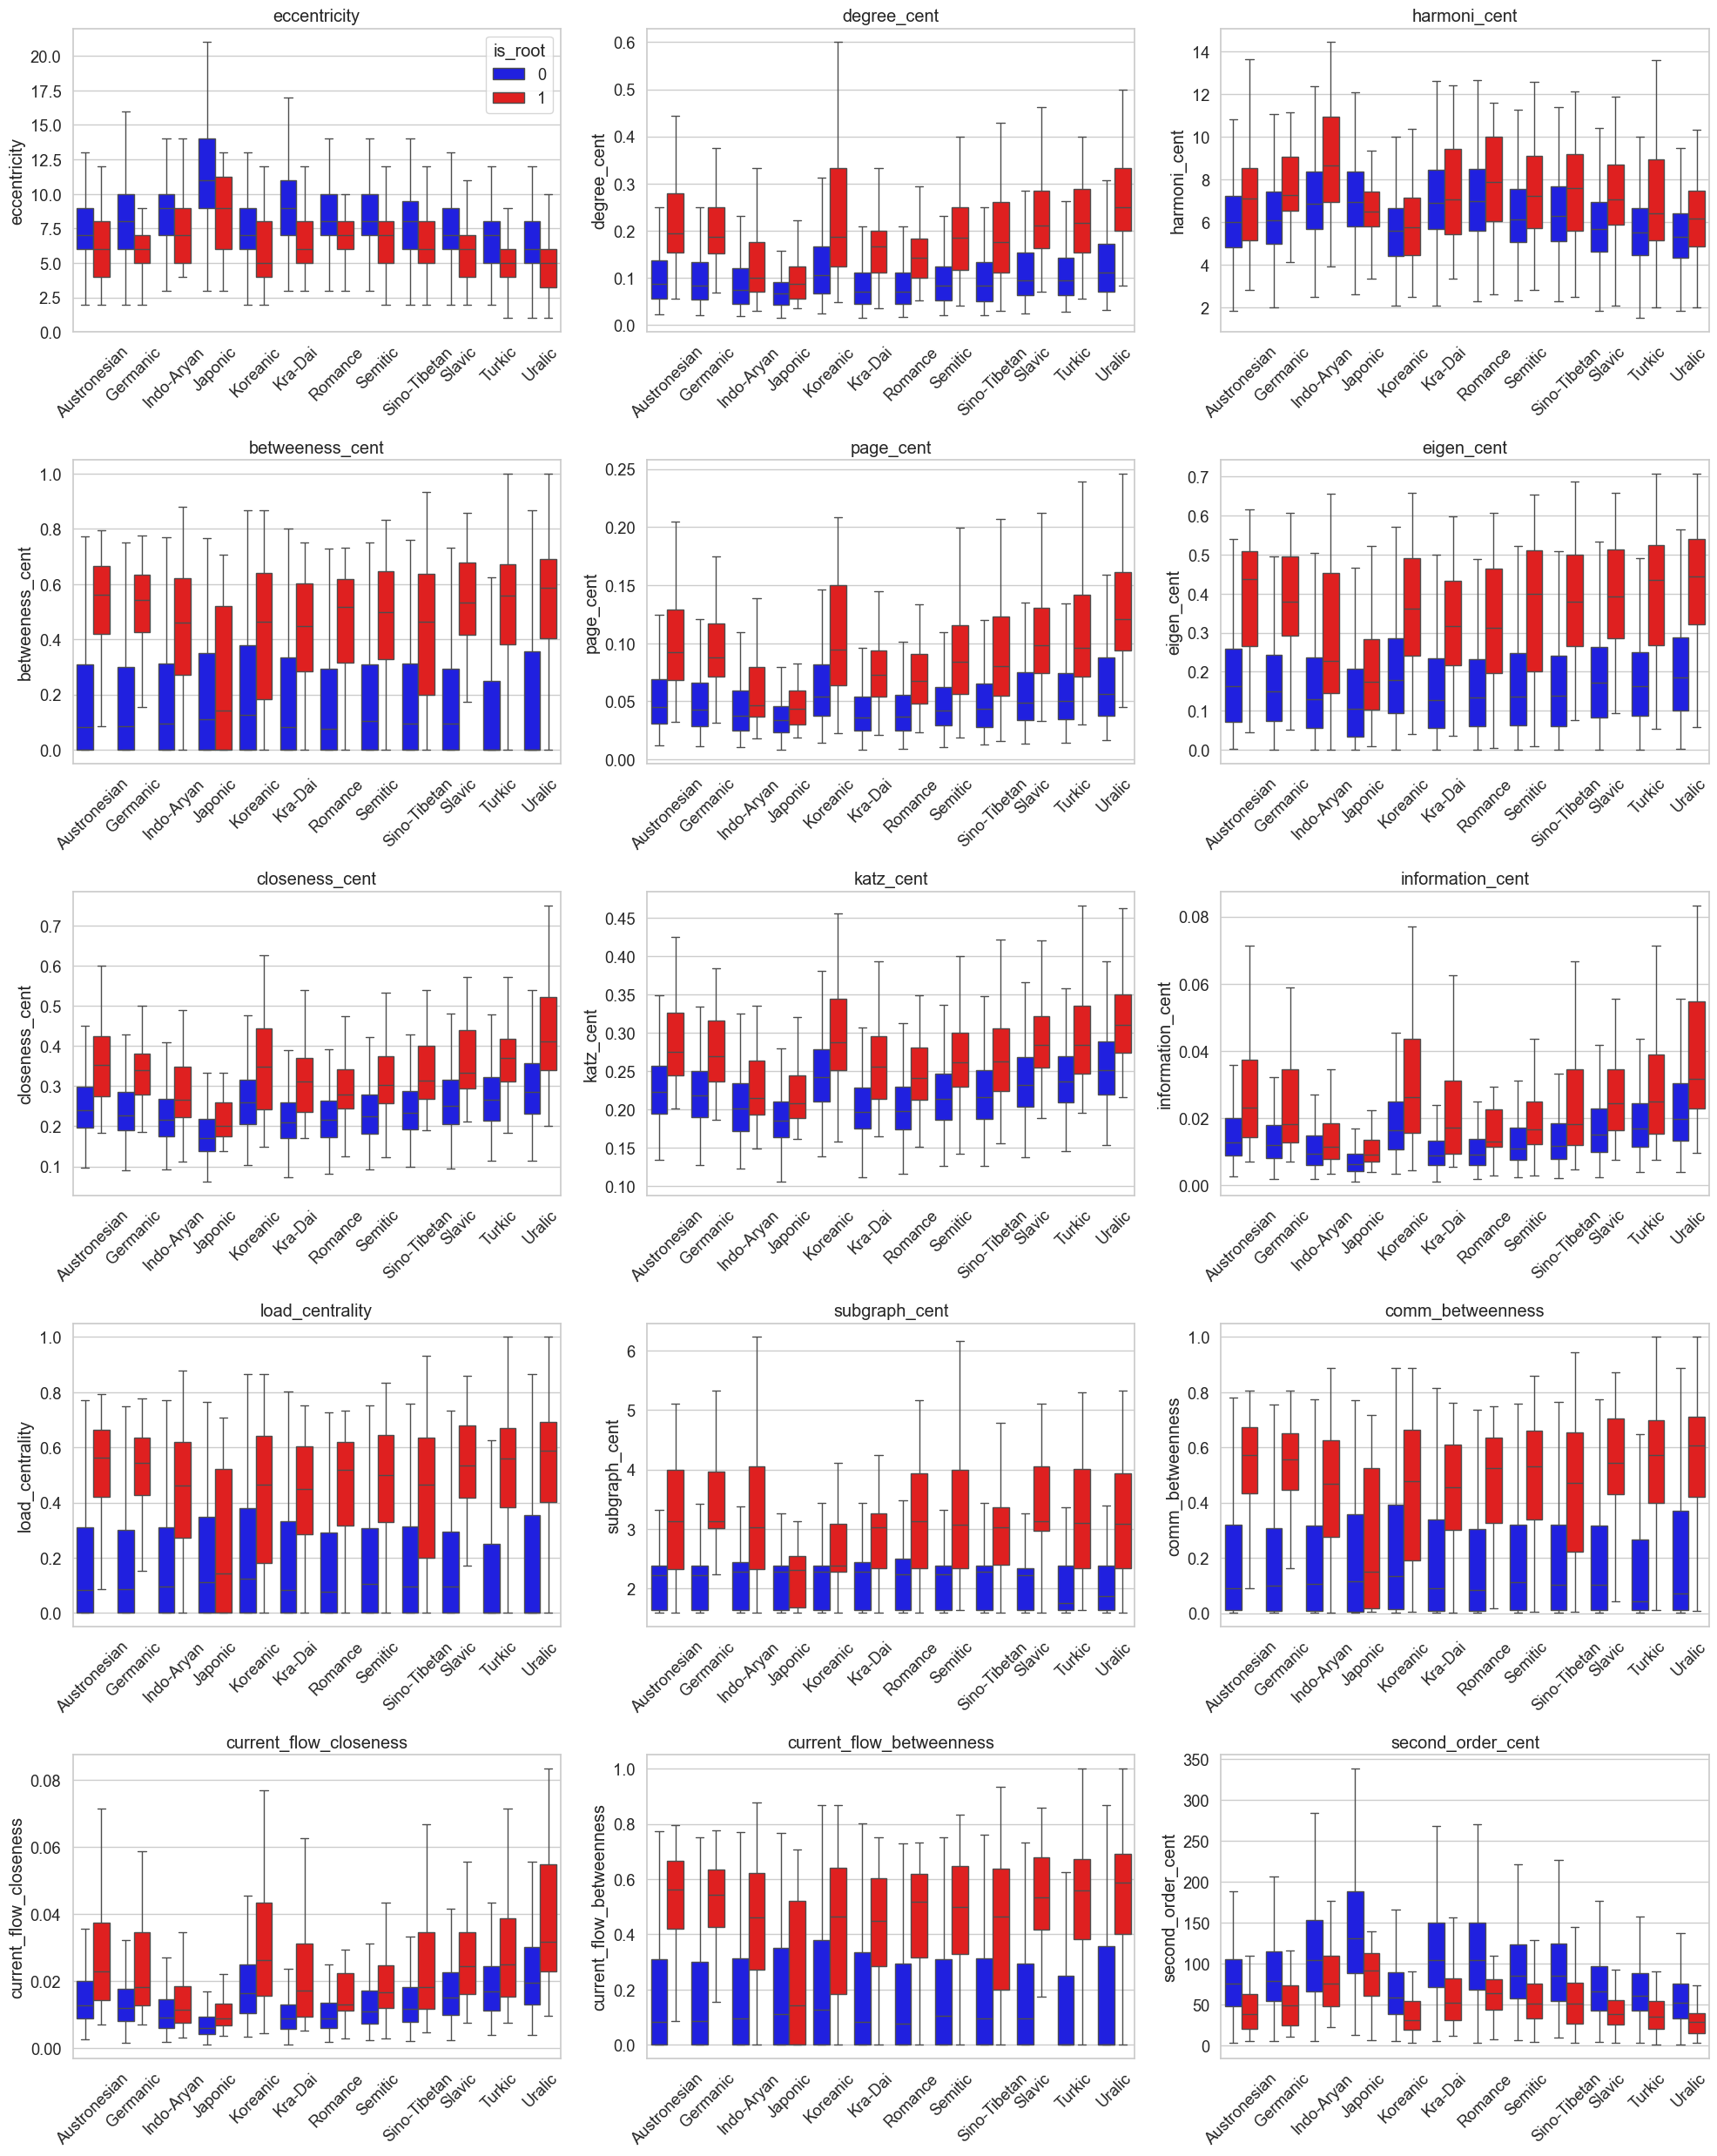


=== Topology Features ===


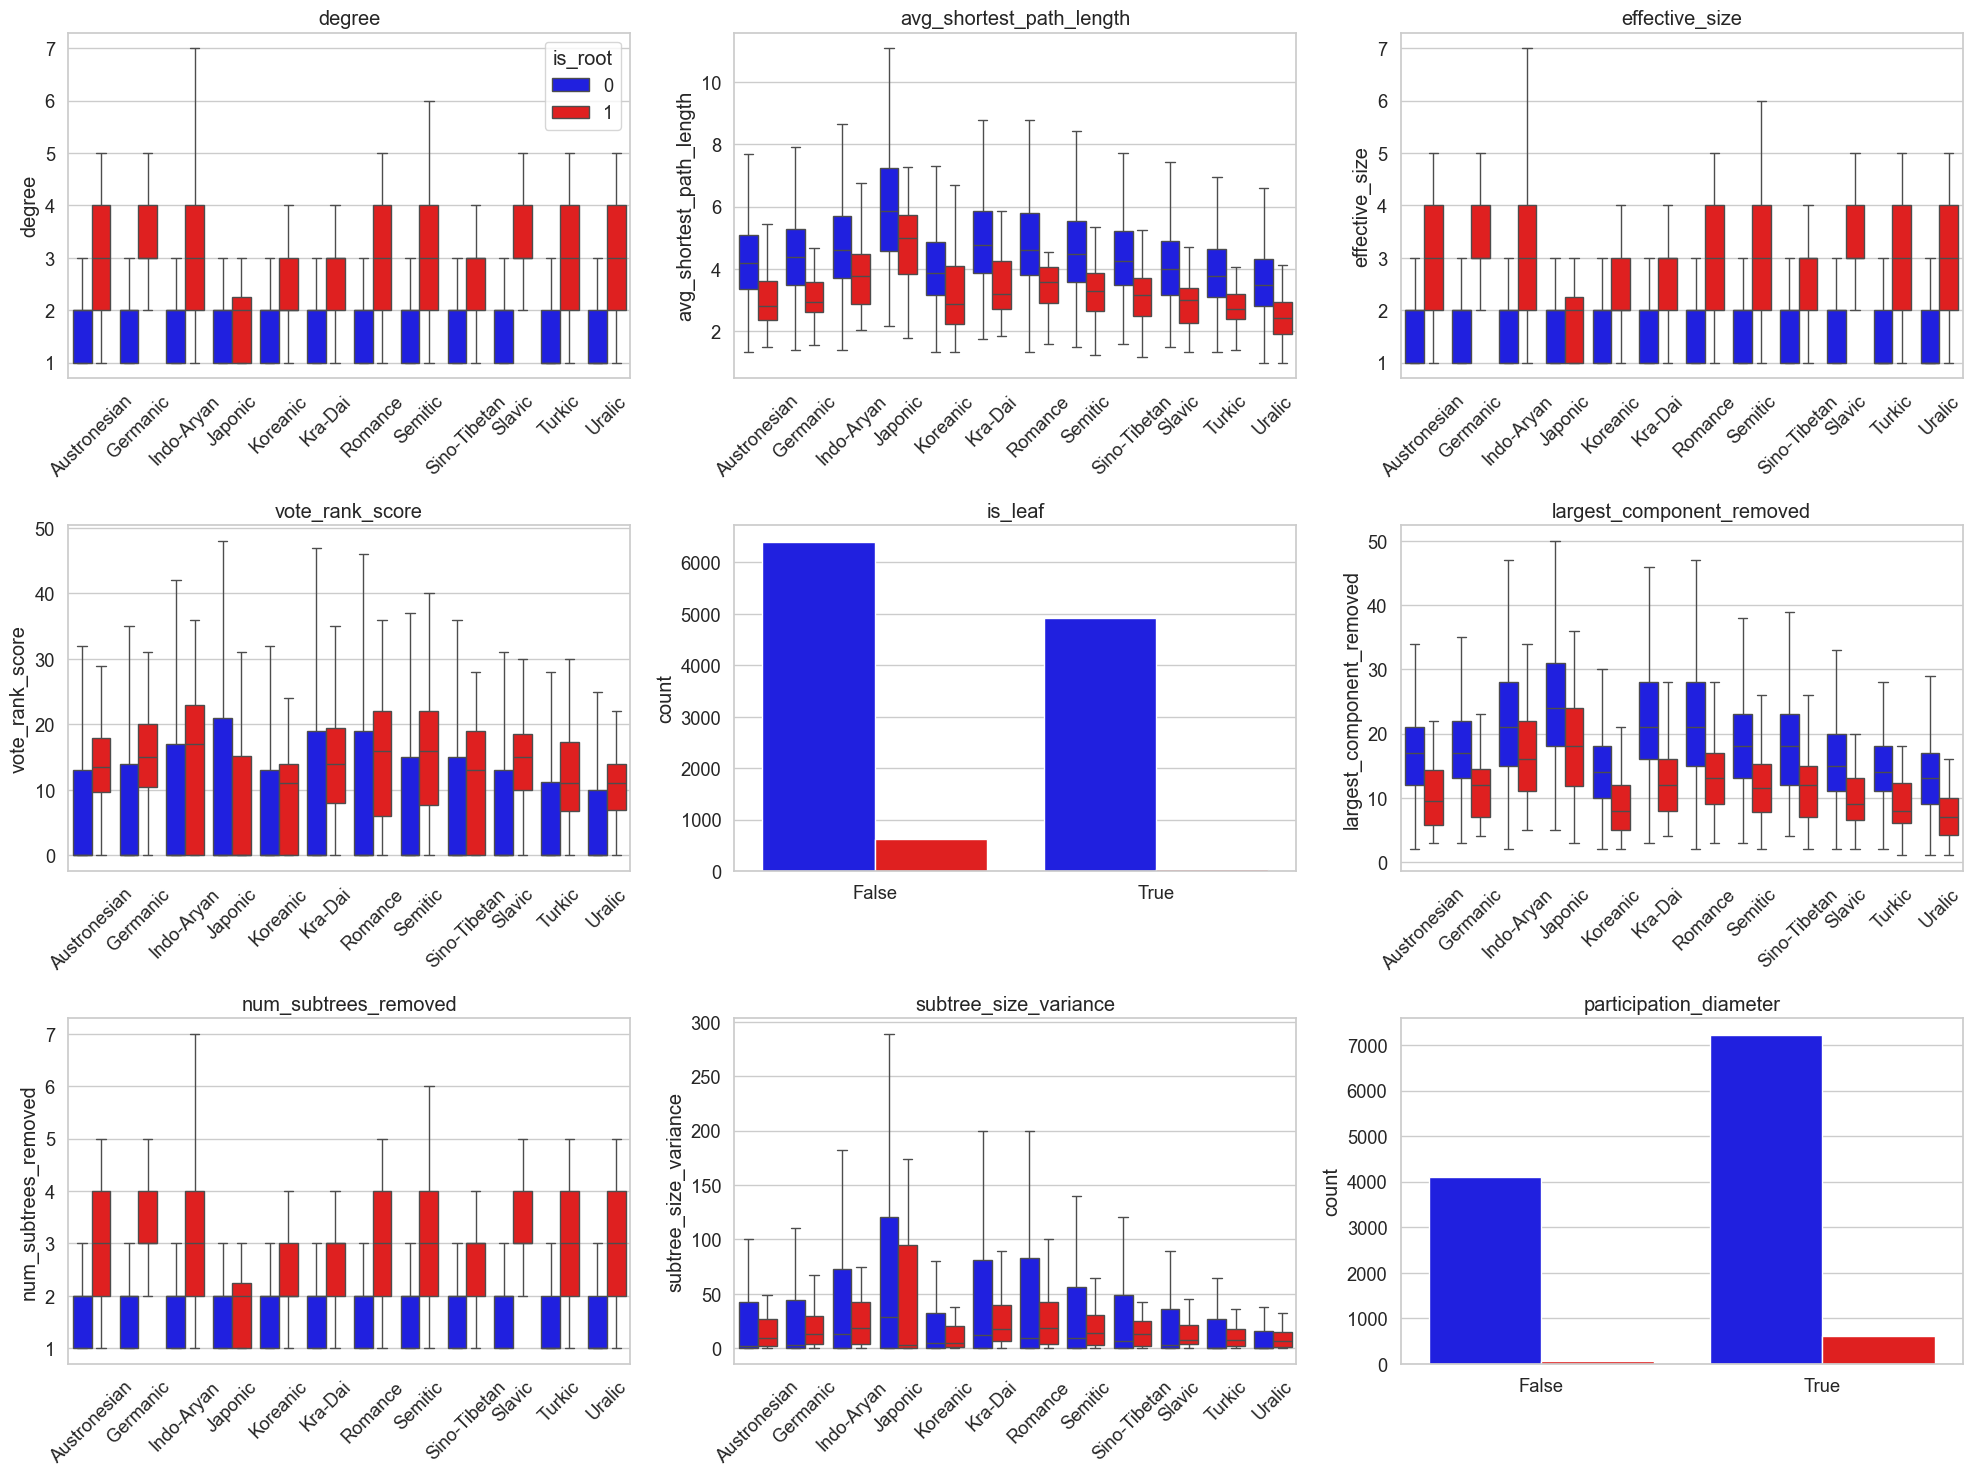


=== Neighborhood Features ===


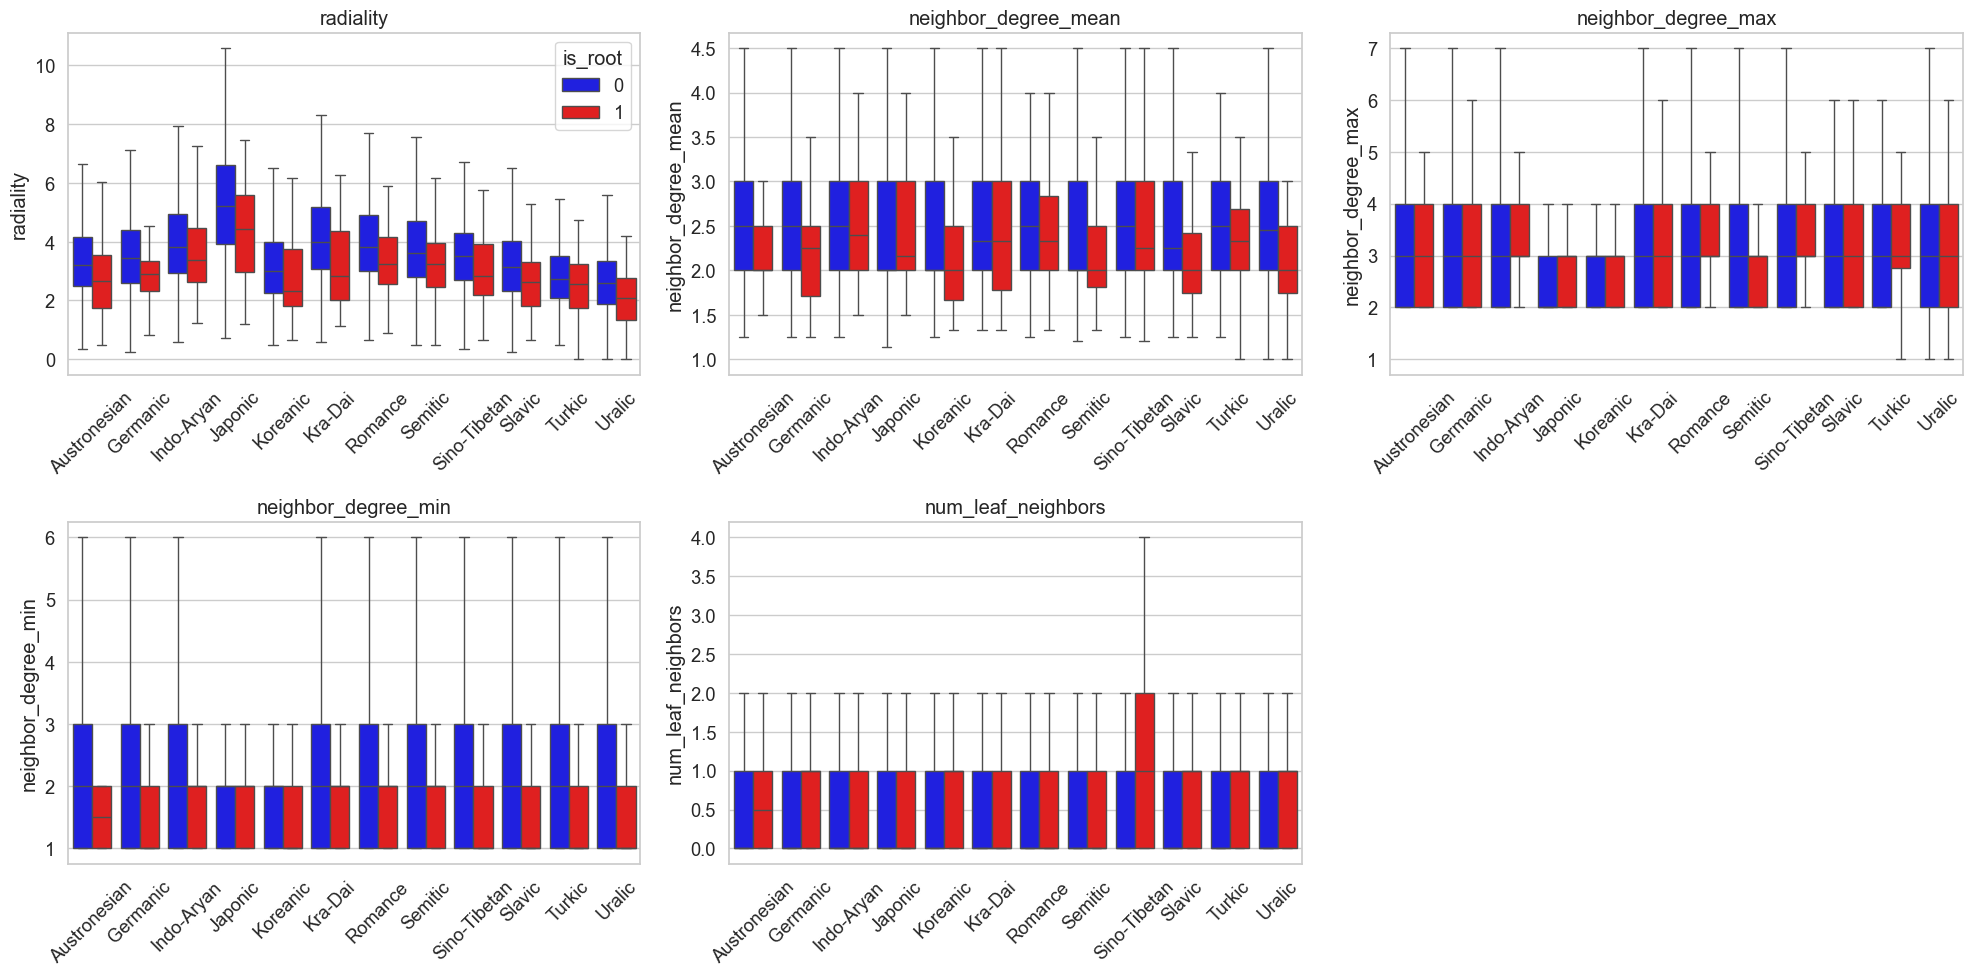

In [16]:
# Group features by type
feature_groups = {
    'Centrality': node_features[:15],
    'Topology': node_features[15:24],
    'Neighborhood': node_features[24:]
}

# Plot each feature group
for group_name, features in feature_groups.items():
    print(f"\n=== {group_name} Features ===")
    
    # Create subplots
    n_cols = 3
    n_rows = int(np.ceil(len(features)/n_cols))
    
    plt.figure(figsize=(20, 5*n_rows))
    
    for i, feat in enumerate(features, 1):
        ax = plt.subplot(n_rows, n_cols, i)
        
        if feat in ['is_leaf', 'participation_diameter']:
            # Binary features - count plot
            sns.countplot(data=df, x=feat, hue='is_root', 
                         palette={0: 'blue', 1: 'red'}, ax=ax)
        else:
            # Continuous features - boxplot
            sns.boxplot(data=df, x='language_group', y=feat, 
                       hue='is_root', palette={0: 'blue', 1: 'red'},
                       showfliers=False, ax=ax)
            plt.xticks(rotation=45)
        
        ax.set_title(feat)
        ax.set_xlabel('')
        if i != 1: ax.get_legend().remove()
    
    plt.tight_layout()
    plt.show()

## 3. Feature Correlation Analysis

/var/folders/lr/ysc7n3fx6sv02d60ctrl7k_r0000gn/T/ipykernel_11369/1834816217.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


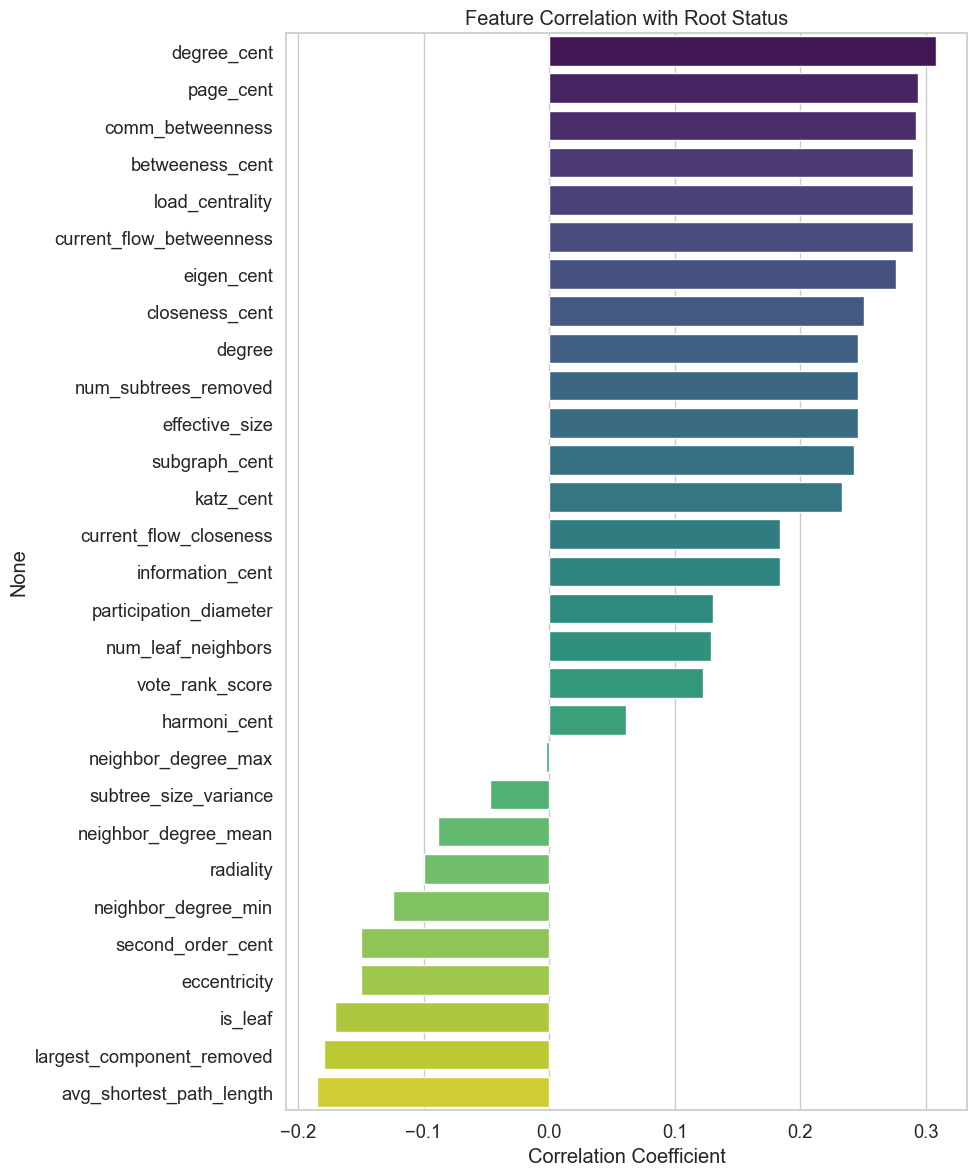

In [5]:
# Calculate correlations with root status
correlations = df[node_features].corrwith(df['is_root']).sort_values(ascending=False)

# Plot top correlated features
plt.figure(figsize=(10, 12))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.title("Feature Correlation with Root Status")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

## 4. Language-Specific Feature Importance

  0%|          | 0/12 [00:00<?, ?it/s]

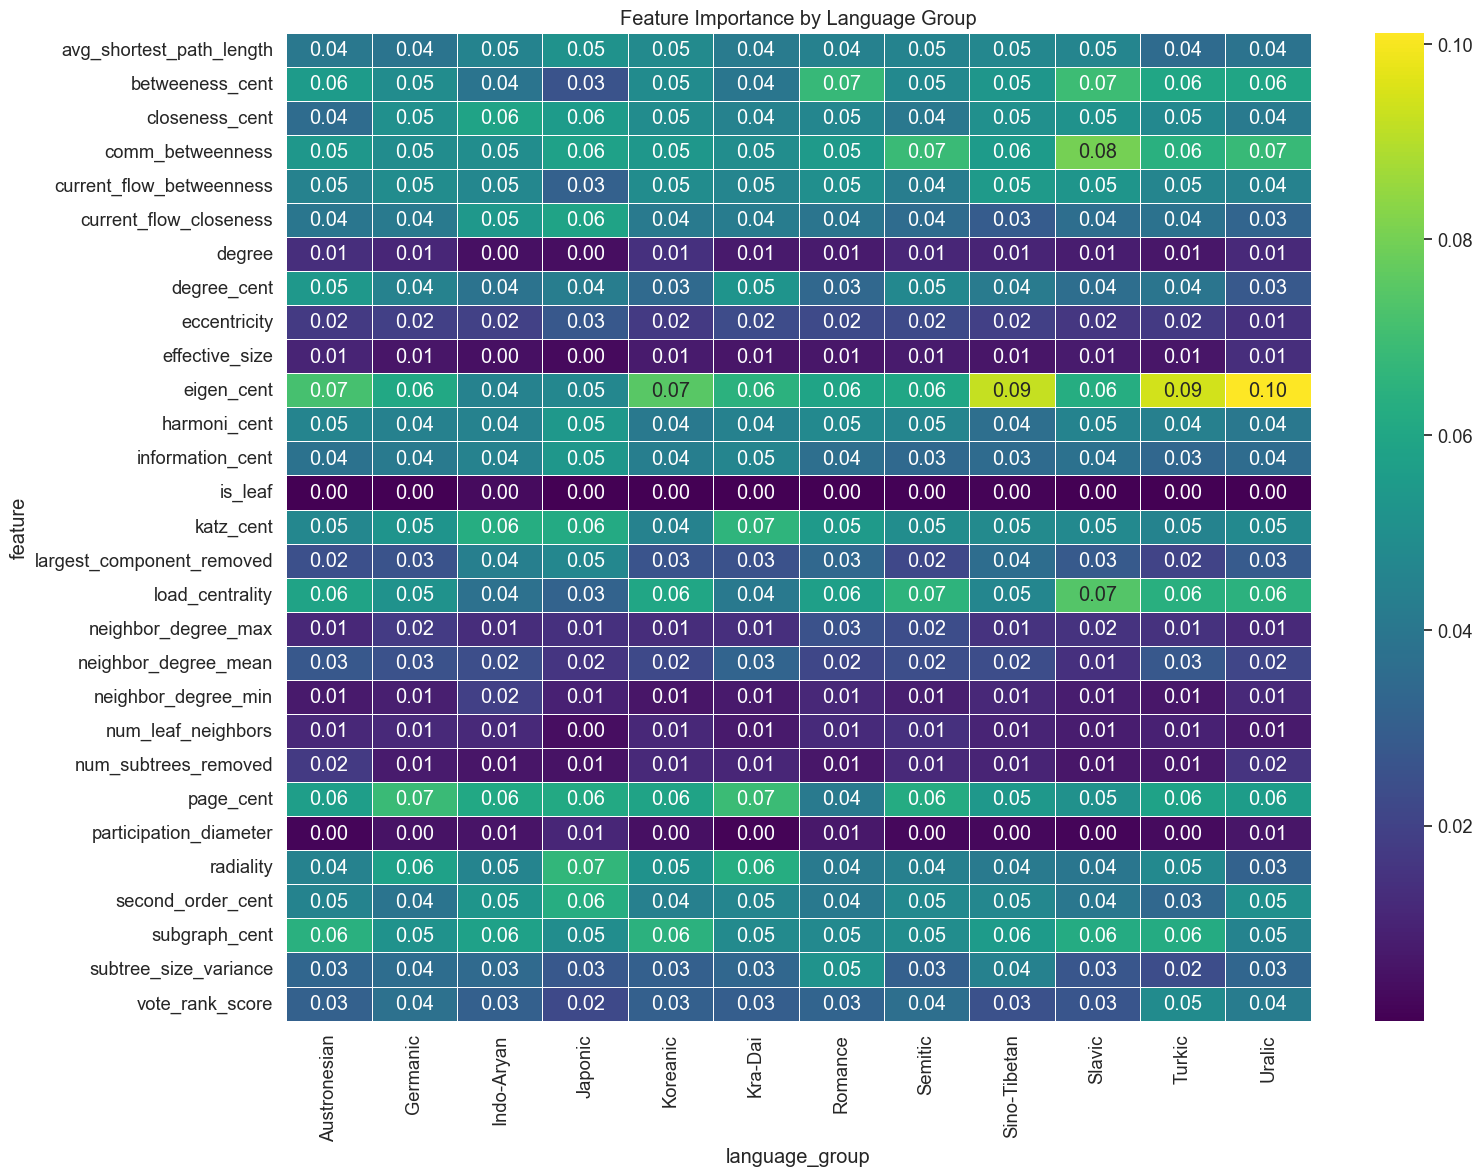

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare importance dataframe
importance_results = []

for lang_group in tqdm(df['language_group'].unique()):
    lang_data = df[df['language_group'] == lang_group]
    
    if len(lang_data['is_root'].unique()) > 1:  # Need both classes
        X = lang_data[node_features]
        y = lang_data['is_root']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        
        for i, feat in enumerate(node_features):
            importance_results.append({
                'language_group': lang_group,
                'feature': feat,
                'importance': clf.feature_importances_[i]
            })

# Plot importance heatmap
if importance_results:
    importance_df = pd.DataFrame(importance_results)
    
    # Corrected pivot syntax - use named parameters
    pivot_df = importance_df.pivot(
        index='feature',
        columns='language_group',
        values='importance'
    )
    
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        pivot_df,
        cmap='viridis',
        annot=True,
        fmt=".2f",
        linewidths=.5
    )
    plt.title("Feature Importance by Language Group")
    plt.tight_layout()
    plt.show()